In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Data

In [114]:
import urllib  # the lib that handles the url stuff

data = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names') # it's a file like object and works just like a file
for line in data: # files are iterable
    print(line)

b'1. Title: Auto-Mpg Data\n'
b'\n'
b'2. Sources:\n'
b'   (a) Origin:  This dataset was taken from the StatLib library which is\n'
b'                maintained at Carnegie Mellon University. The dataset was \n'
b'                used in the 1983 American Statistical Association Exposition.\n'
b'   (c) Date: July 7, 1993\n'
b'\n'
b'3. Past Usage:\n'
b'    -  See 2b (above)\n'
b'    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.\n'
b'       In Proceedings on the Tenth International Conference of Machine \n'
b'       Learning, 236-243, University of Massachusetts, Amherst. Morgan\n'
b'       Kaufmann.\n'
b'\n'
b'4. Relevant Information:\n'
b'\n'
b'   This dataset is a slightly modified version of the dataset provided in\n'
b'   the StatLib library.  In line with the use by Ross Quinlan (1993) in\n'
b'   predicting the attribute "mpg", 8 of the original instances were removed \n'
b'   because they had unknown values for the "mpg" attribute.  The original \n'
b'   d

In [115]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', delim_whitespace=True, names=column_names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# Data cleaning

In [116]:
df = df.replace('?', np.nan)
df = df.dropna()
df['horsepower'] = df['horsepower'].astype(float)
#df['origin'] = df['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Data visualisation

In [117]:
independant_var = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']

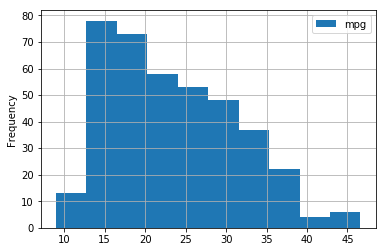

In [118]:
df.plot(kind='hist', y='mpg', grid=True)

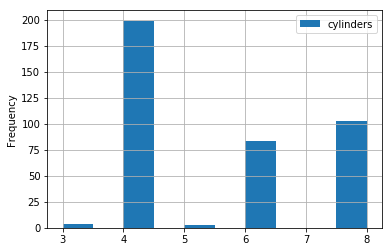

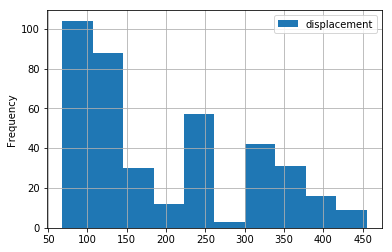

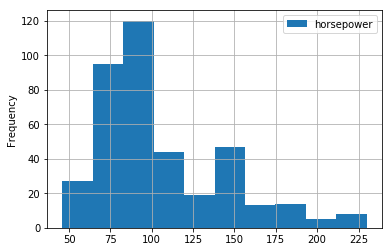

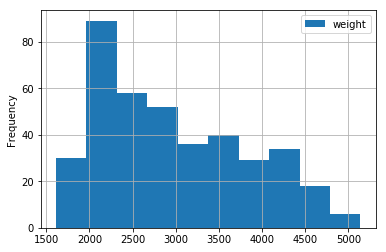

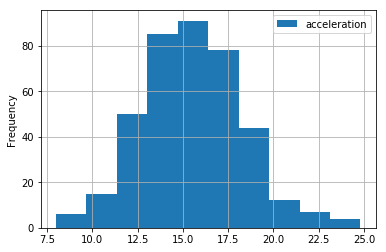

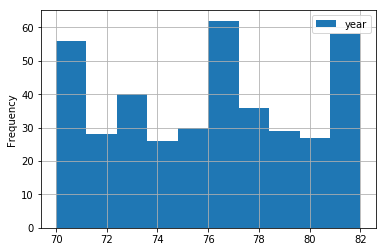

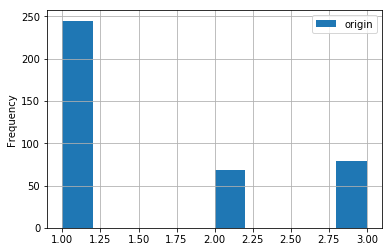

In [119]:
for param in independant_var:
    try:
        df.plot(kind='hist', y=param, grid=True)
    except:
        df[param].value_counts().plot(kind='bar', grid=True)

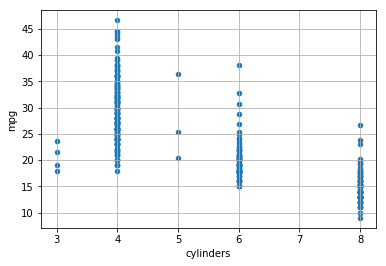

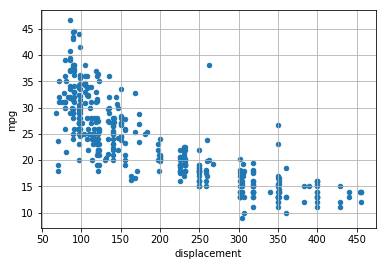

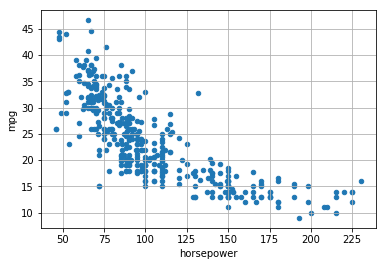

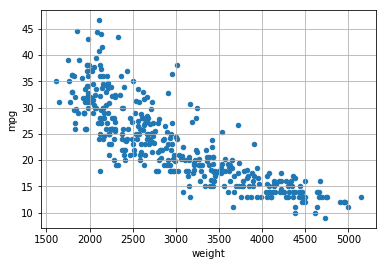

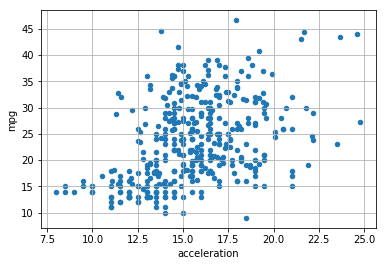

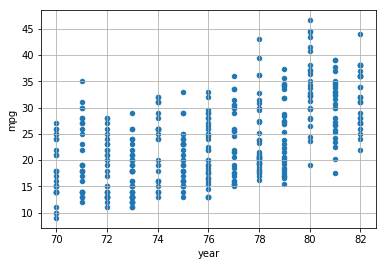

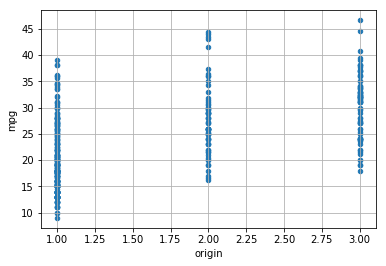

In [120]:
for param in independant_var:
    df.plot(kind='scatter', x=param, y='mpg', grid=True)

# Model
Aim is to model mpg (miles per gallon) from information contained in the dataset

# Tensorflow with lattice

In [121]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc

print(tf.__version__)

2.2.0


In [122]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [123]:
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 1000

In [124]:
train_size = int(len(df) * 0.8)

target = df.pop('mpg')
train_x = df[:train_size]
train_y = target[:train_size]
test_x = df[train_size:]
test_y = target[train_size:]

In [125]:
feature_columns = [
    fc.numeric_column('cylinders'),
    fc.numeric_column('displacement'),
    fc.numeric_column('weight'),
    fc.numeric_column('year'),
    fc.numeric_column('horsepower'),
    fc.numeric_column('acceleration'),
    fc.categorical_column_with_vocabulary_list('origin', [1, 2, 3]),
]

In [126]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_x,
    y=train_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    num_threads=1)

# feature_analysis_input_fn is used to collect statistics about the input.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_x,
    y=train_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    # Note that we only need one pass over the data.
    num_epochs=1,
    num_threads=1)

test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=test_x,
    y=test_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    num_threads=1)

# Serving input fn is used to create saved models.
serving_input_fn = (
    tf.estimator.export.build_parsing_serving_input_receiver_fn(
        feature_spec=fc.make_parse_example_spec(feature_columns)))

In [228]:
n_keypoints = 5
n_lattice = 2
feature_configs = [
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='cylinders',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints='uniform',

    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='displacement',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints='uniform',
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='weight',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints='uniform',
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='year',
        monotonicity='increasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints='uniform',
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='horsepower',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints='uniform',
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='acceleration',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints='uniform',
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='origin',
        num_buckets=3,
    ),
]

In [229]:
# Model config defines the model structure for the premade model.
model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=feature_configs,
    output_min=train_y.min(),
    output_max=train_y.max(),
    output_calibration=True,
    output_calibration_num_keypoints=n_keypoints,
    output_initialization=np.linspace(train_y.min(), train_y.max(), num=n_keypoints),
)

In [230]:
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedRegressor(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Calibrated linear test MSE: {}'.format(results['prediction/mean']))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/1p/22y65v150sq4bm61h22w1f6c0000gn/T/tmp0i9_1tn6', '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replica

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: ['serving_default', 'regression']
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /var/folders/1p/22y65v150sq4bm61h22w1f6c0000gn/T/tmp0i9_1tn6/model.ckpt-2446
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /var/folders/1p/22y65v150sq4bm61h22w1f6c0000gn/T/tmp0i9_1tn6/temp-1601643768/saved_model.pb
INFO:tensorflow:Restoring parameters from /var/folders/1p/22y65v150sq4bm61h22w1f6c0000gn/T/tmp0i9_1tn6/1601643768/variables/variables


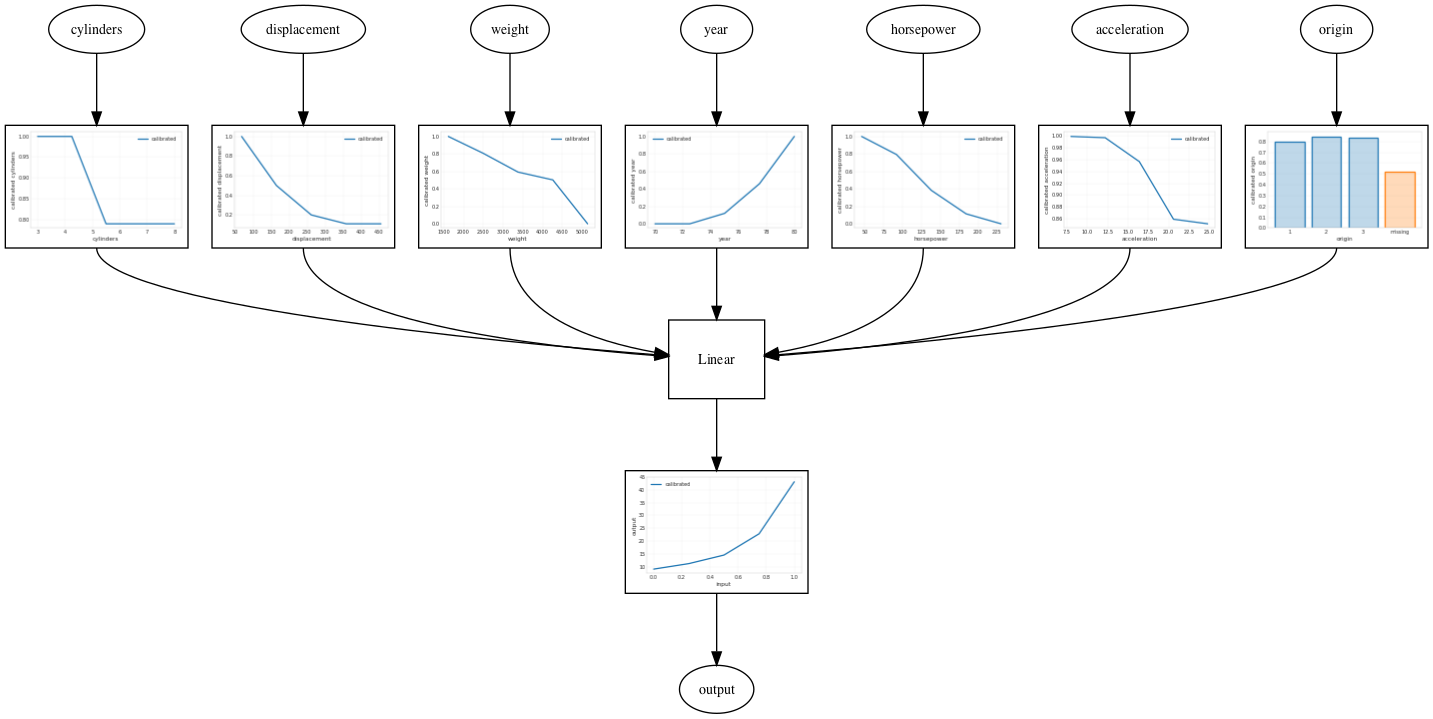

In [231]:
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph)

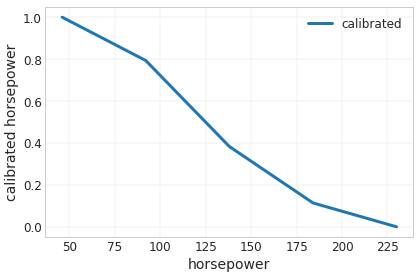

In [232]:
_ = tfl.visualization.plot_feature_calibrator(model_graph, "horsepower")

In [233]:
test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=pd.concat([train_x, test_x]),
    y=pd.concat([train_y, test_y]),
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    num_threads=1)

In [234]:
from sklearn.metrics import mean_squared_error, r2_score

pred = estimator.predict(input_fn=test_input_fn)
pred = np.array([x['predictions'][0] for x in pred])
df['MPG_pred'] = pred
df['mpg'] = pd.concat([train_y, test_y]).values
df['delta_mpg'] = df['MPG_pred'] - df['mpg']


print(
    'scores\nmse={:.2f}\nr2={:.2f}\n'.\
    format(mean_squared_error(df['MPG_pred'], df['mpg']),
           r2_score(df['MPG_pred'], df['mpg'])
          )
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/1p/22y65v150sq4bm61h22w1f6c0000gn/T/tmp0i9_1tn6/model.ckpt-2446
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
scores
mse=7.34
r2=0.86



/Users/thomas/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


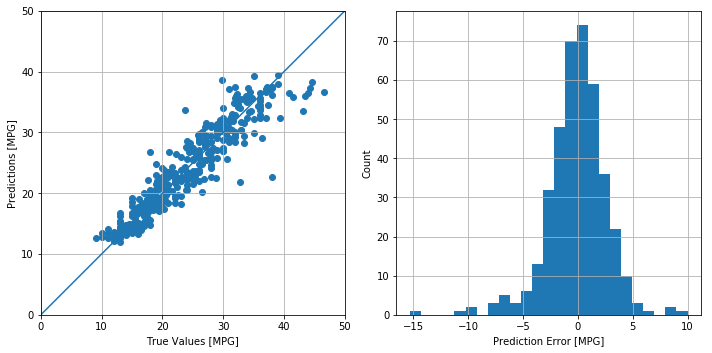

In [235]:
pred = estimator.predict(input_fn=test_input_fn)

fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].scatter(df['mpg'], df['MPG_pred'])
ax[0].set_xlabel('True Values [MPG]')
ax[0].set_ylabel('Predictions [MPG]')
lims = [0, 50]
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[0].plot(lims, lims)
ax[0].set_aspect('equal')
ax[0].grid('on')

pred = estimator.predict(input_fn=test_input_fn)

ax[1].hist(df['delta_mpg'], bins = 25)
ax[1].set_xlabel("Prediction Error [MPG]")
ax[1].set_ylabel("Count")
#ax[1].set_aspect('equal')
ax[1].grid('on')

plt.tight_layout()

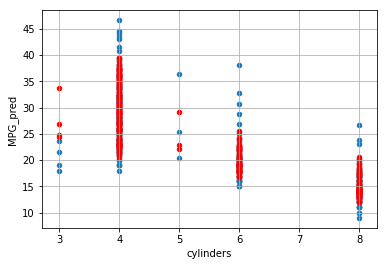

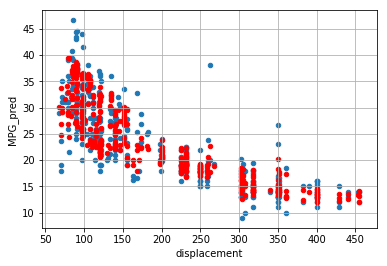

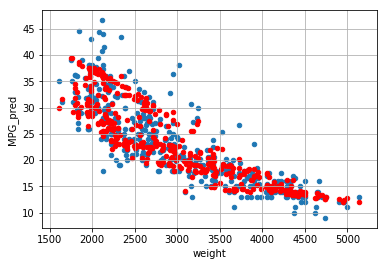

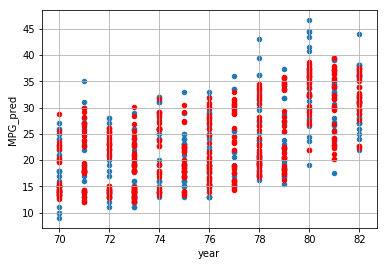

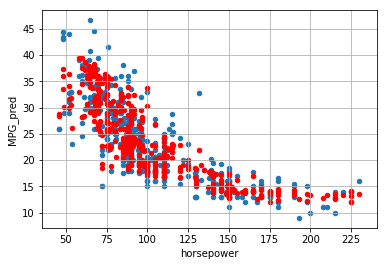

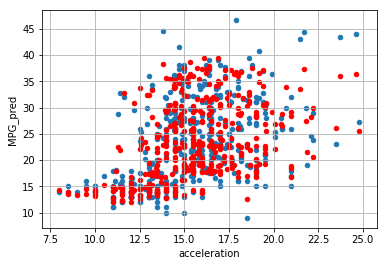

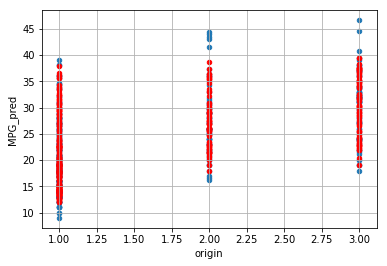

In [236]:
for param in [feature.key for feature in feature_columns]:
    ax = df.plot(kind='scatter', x=param, y='mpg', grid=True)
    df.plot(kind='scatter', x=param, y='MPG_pred', grid=True, ax=ax, c='r')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/1p/22y65v150sq4bm61h22w1f6c0000gn/T/tmp0i9_1tn6/model.ckpt-2446
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


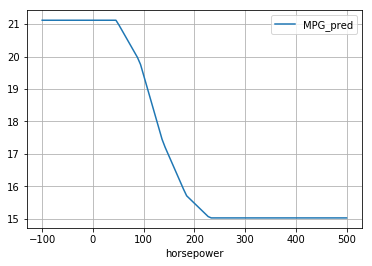

In [237]:
df_tmp = pd.DataFrame()
main_independant_var = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'acceleration', 'origin']


df_tmp['cylinders'] = [6]*100#np.linspace(0, 10, 100)#
df_tmp['displacement'] = 250#np.linspace(0, 500, 100)#200
df_tmp['weight'] = 3000#np.linspace(0, 10000, 100)#[5000]*100
df_tmp['year'] = 76#[70, 80]*50
df_tmp['horsepower'] = np.linspace(-100, 500, 100)
df_tmp['acceleration'] = 15#np.linspace(0, 30, 100)#20
df_tmp['origin'] = 1
df_tmp['mpg'] = 0

y = df_tmp.pop('mpg')
x = df_tmp

test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x,
    y=y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    num_threads=1)

pred = estimator.predict(input_fn=test_input_fn)
pred = np.array([x['predictions'][0] for x in pred])
df_tmp['MPG_pred'] = pred


ax = df_tmp.plot(kind='line', x='horsepower', y='MPG_pred', grid=True)